# Phase 0 – Encoder & Embedding Basics (Text + Vision–Text)

Goal of this notebook:

1. Get comfortable with **text embeddings** using a sentence encoder (MiniLM).
2. Run a **vision–text model (CLIP)** on a real dataset (PixMo-Cap).
3. Build a **similarity matrix** and use it for:
   - Text–text similarity
   - Image–text retrieval (caption → image, image → caption)
4. Visualize a **heatmap** of image–caption similarities.

We will NOT train anything here. We are just probing frozen encoders.


### 1.1 Imports & matplotlib setup

In [1]:

from datasets import load_dataset
from PIL import Image
from io import BytesIO
import random
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import numpy as np

from sentence_transformers import SentenceTransformer
from transformers import CLIPModel, CLIPProcessor

from sklearn.metrics.pairwise import cosine_similarity
random.seed(42)

/home/hice1/vchopra37/scratch/projects/edge_glass/edge_glass_env/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


### 2. Text Embeddings Warmup (POC 0.3 – MiniLM)

#### # 2.1 Load a sentence embedding model (MiniLM)

In [ ]:
text_model_name = "sentence-transformers/all-MiniLM-L6-v2"
text_encoder = SentenceTransformer(text_model_name, device=device)

print("Loaded text encoder:", text_model_name)
print("Device:", device)

Loaded text encoder: sentence-transformers/all-MiniLM-L6-v2
Device: cuda


#### # 2.2 Define some sentences (grouped into rough "themes")

In [ ]:
sentences = [
    # Weather theme
    "It is going to rain heavily today.",
    "The forecast predicts a lot of rainfall.",
    "The weather will be sunny and clear.",

    # Travel theme
    "I am flying to New York tomorrow.",
    "My flight to NYC is scheduled for the morning.",
    "I love traveling to big cities.",

    # Random theme
    "A dog is playing in the park.",
    "A man is giving a speech.",
    "A small airplane is flying in the sky.",
    "I enjoy eating spicy food."
]

len(sentences), sentences[:3]


(10,
 ['It is going to rain heavily today.',
  'The forecast predicts a lot of rainfall.',
  'The weather will be sunny and clear.'])

#### 2.3 Encode sentences and inspect shapes

In [7]:
# 2.3 Encode sentences → embeddings (N, d)

text_emb = text_encoder.encode(
    sentences,
    convert_to_numpy=True,
    normalize_embeddings=True   # L2-normalized → cosine == dot product
)

print("Embeddings shape:", text_emb.shape)   # (N, d)
print("First 5 dims of first embedding:", text_emb[0][:5])


Embeddings shape: (10, 384)
First 5 dims of first embedding: [-0.00589108  0.03916033  0.1124286   0.01731584  0.05457148]


#### 2.4 Text–text similarity 
<p>

Interpretation:

Diagonal ≈ 1

Off-diagonal entries show sentence similarity (“dog vs airplane” should be low).

💡 Takeaway: A text encoder is just a function list[str] → 2D array (n, d).

</p>

In [8]:
# 2.4 Compute pairwise cosine similarity between all sentences

sim_mat = cosine_similarity(text_emb, text_emb)
print("Similarity matrix shape:", sim_mat.shape)

# Round just for nicer printing
print(np.round(sim_mat, 2))


Similarity matrix shape: (10, 10)
[[ 1.    0.62  0.57  0.33  0.33  0.16  0.05  0.05  0.08 -0.05]
 [ 0.62  1.    0.51  0.17  0.26  0.13  0.01  0.07  0.12 -0.08]
 [ 0.57  0.51  1.    0.33  0.31  0.17  0.03  0.05  0.2   0.02]
 [ 0.33  0.17  0.33  1.    0.79  0.41  0.07  0.01  0.31  0.09]
 [ 0.33  0.26  0.31  0.79  1.    0.32  0.08  0.01  0.28  0.09]
 [ 0.16  0.13  0.17  0.41  0.32  1.    0.06 -0.06  0.13  0.29]
 [ 0.05  0.01  0.03  0.07  0.08  0.06  1.    0.04  0.09  0.07]
 [ 0.05  0.07  0.05  0.01  0.01 -0.06  0.04  1.   -0.   -0.02]
 [ 0.08  0.12  0.2   0.31  0.28  0.13  0.09 -0.    1.   -0.05]
 [-0.05 -0.08  0.02  0.09  0.09  0.29  0.07 -0.02 -0.05  1.  ]]


#### 2.5 Inspect nearest neighbors by text similarity

In [9]:
# 2.5 For each sentence, print its top-3 most similar sentences

def print_topk_similar(sentences, sim_mat, k=3):
    n = len(sentences)
    for i in range(n):
        sims = sim_mat[i]
        # sort indices by similarity, descending
        top_indices = np.argsort(-sims)[:k+1]  # includes itself at index 0

        print(f"\nSentence [{i}]: {sentences[i]}")
        for rank, j in enumerate(top_indices):
            print(f"  rank {rank}: idx={j}, sim={sims[j]:.3f}, text={sentences[j]}")

print_topk_similar(sentences, sim_mat, k=3)



Sentence [0]: It is going to rain heavily today.
  rank 0: idx=0, sim=1.000, text=It is going to rain heavily today.
  rank 1: idx=1, sim=0.619, text=The forecast predicts a lot of rainfall.
  rank 2: idx=2, sim=0.566, text=The weather will be sunny and clear.
  rank 3: idx=4, sim=0.326, text=My flight to NYC is scheduled for the morning.

Sentence [1]: The forecast predicts a lot of rainfall.
  rank 0: idx=1, sim=1.000, text=The forecast predicts a lot of rainfall.
  rank 1: idx=0, sim=0.619, text=It is going to rain heavily today.
  rank 2: idx=2, sim=0.509, text=The weather will be sunny and clear.
  rank 3: idx=4, sim=0.262, text=My flight to NYC is scheduled for the morning.

Sentence [2]: The weather will be sunny and clear.
  rank 0: idx=2, sim=1.000, text=The weather will be sunny and clear.
  rank 1: idx=0, sim=0.566, text=It is going to rain heavily today.
  rank 2: idx=1, sim=0.509, text=The forecast predicts a lot of rainfall.
  rank 3: idx=3, sim=0.328, text=I am flying t

#### 2.6 (Optional) Small visualization of similarity matrix

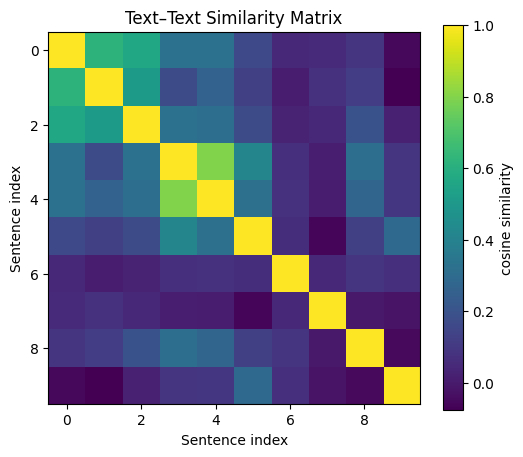

In [10]:
# 2.6 Visualize the text–text similarity matrix as a heatmap

plt.figure(figsize=(6, 5))
plt.imshow(sim_mat, interpolation="nearest")
plt.colorbar(label="cosine similarity")
plt.title("Text–Text Similarity Matrix")
plt.xlabel("Sentence index")
plt.ylabel("Sentence index")
plt.show()


### 3. Vision and Text Encoder Experiments

#### 3.1 Load a Tiny Vision–Text Dataset (PixMo-Cap)

In [11]:
# 3.1 Load a small subset of allenai/pixmo-cap

N_EXAMPLES = 10  # keep this small for probing

pixmo_ds = load_dataset("allenai/pixmo-cap", split=f"train[:{N_EXAMPLES}]")
print("PixMo subset length:", len(pixmo_ds))
pixmo_ds[0]


PixMo subset length: 10


{'image_url': 'https://pixmo.s3.us-west-2.amazonaws.com/birds/1491.png',
 'caption': "This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall with red stains. The bird's sleek, elongated body is adorned with iridescent feathers that shimmer with shades of blue, purple, and green, most prominently on its wings and back. Its piercing yellow eye and long, sharp beak lend it a fierce, almost aerodynamic appearance. The bird's dark, slender legs and short talons grip the edge of the cement structure, which resembles a divider or barrier, possibly in an outdoor setting like a park or building patio. The background is a blur of green and white hues, hinting at lush tropical plants and tall trees, setting a serene, natural scene. The bird is poised, looking towards the upper right-hand corner of the frame, with its long tail feathers trailing elegantly to the left.",
 'transcripts': ["This is a picture of a long black bird with a lot

#### 3.2 Inspect a random sample

Keys: dict_keys(['image_url', 'caption', 'transcripts'])
Image URL: https://www.pacifichorticulture.org/wp-content/uploads/2003/07/2003_JAS-GRAVES-002.jpg
Caption: The image displays an illustration, possibly in a journal or textbook, showcasing a branch with green leaves and both mature and immature acorns. Despite some of the leaves appearing damaged or aged, the branch prominently features an acorn below the leaves and two small, developing acorns. The text "Quercus parvula var. shrevei, Yerba Buena Nursery" is handwritten at the bottom left, suggesting it might be a botanical reference. The page itself is white, and the faint outlines of text from the reverse side are visible, adding to the impression of an academic or botanical documentation. Additionally, a faint gray drawing of a tree appears in the bottom right corner, likely representing the acorn-bearing tree.


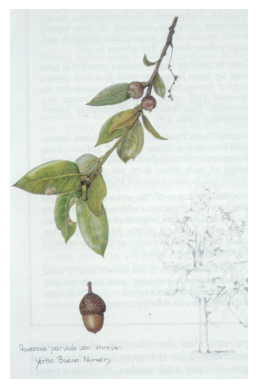

In [14]:
# 3.2 Inspect a random sample: show image + caption

idx = random.randint(0, len(pixmo_ds)-1)
sample = pixmo_ds[idx]

print("Keys:", sample.keys())
print("Image URL:", sample['image_url'])
print("Caption:", sample['caption'])

response = requests.get(sample['image_url'])
img = Image.open(BytesIO(response.content)).convert("RGB")

plt.imshow(img)
plt.axis("off")
# plt.title(sample['caption'])
plt.show()


### 4. Prepare a Small Image–Caption Batch

In [15]:
# 4. Prepare small lists of images + captions

images = []
captions = []

for i in range(len(pixmo_ds)):
    cap = pixmo_ds[i]["caption"].strip()
    url = pixmo_ds[i]["image_url"]

    try:
        resp = requests.get(url, timeout=10)
        if resp.status_code != 200:
            print(f"Skipping index {i}: HTTP {resp.status_code}")
            continue
        img = Image.open(BytesIO(resp.content)).convert("RGB")
    except Exception as e:
        print(f"Error fetching image at index {i}: {e}")
        continue

    captions.append(cap)
    images.append(img)

print(f"Loaded {len(images)} images and {len(captions)} captions.")


Loaded 10 images and 10 captions.


#### 4.1 Quick visual grid of image–caption pairs (optional)

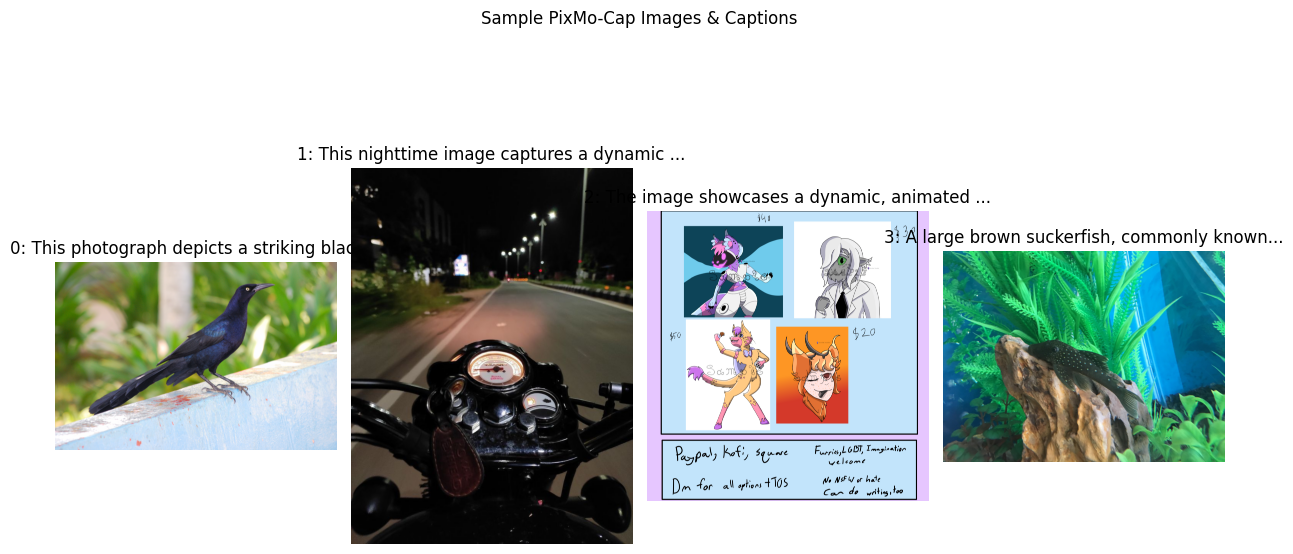

In [16]:
# 4.1 Show a small grid of images with captions to get a feel for the data

n_show = min(4, len(images))

plt.figure(figsize=(12, 6))
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(f"{i}: {captions[i][:40]}...")
plt.suptitle("Sample PixMo-Cap Images & Captions", y=1.05)
plt.tight_layout()
plt.show()


### 5. Load CLIP encoder (image + text)

CLIP’s text encoder can only handle up to 77 tokens (this is hard-coded in the model). One (or more) of your captions becomes 366 tokens after tokenization.

In [18]:
# 5. Load CLIP model (image encoder + text encoder)

clip_name = "openai/clip-vit-base-patch16"
clip_model = CLIPModel.from_pretrained(clip_name).to(device).eval()
clip_proc  = CLIPProcessor.from_pretrained(clip_name, use_fast=True)

print("Loaded CLIP model:", clip_name)


Loaded CLIP model: openai/clip-vit-base-patch16


### 6. Encode Images & Captions with CLIP

In [19]:
# 6.1 Encode images and captions with CLIP

with torch.no_grad():
    inputs = clip_proc(
        text=captions,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True,   # important: captions longer than 77 tokens are cut
        max_length=77
    ).to(device)

    outputs = clip_model(**inputs)
    img_emb = outputs.image_embeds   # (N, d)
    txt_emb = outputs.text_embeds    # (N, d)


In [20]:
# Normalize → cosine similarity == dot product
img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
txt_emb = txt_emb / txt_emb.norm(dim=-1, keepdim=True)

print("Image embedding shape:", img_emb.shape)
print("Text embedding shape:", txt_emb.shape)

Image embedding shape: torch.Size([10, 512])
Text embedding shape: torch.Size([10, 512])


### 7. Image–Text retrieval with cosine similarity

In [21]:
# 7.1 Build similarity matrix: text_emb @ image_emb^T → (N, N)

# text as queries, images as candidates
sims_text_to_image = (txt_emb @ img_emb.T).cpu().numpy()

print("Similarity matrix shape (text→image):", sims_text_to_image.shape)


Similarity matrix shape (text→image): (10, 10)


#### 7.2 Caption → Best Image

In [22]:
# 7.2 For each caption, find best-matching image

for i, cap in enumerate(captions):
    best_img_idx = sims_text_to_image[i].argmax()
    best_sim = sims_text_to_image[i, best_img_idx]

    print(f"\nCaption [{i}]: {cap}")
    print(f"Best image index: {best_img_idx}, sim={best_sim:.3f}")



Caption [0]: This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall with red stains. The bird's sleek, elongated body is adorned with iridescent feathers that shimmer with shades of blue, purple, and green, most prominently on its wings and back. Its piercing yellow eye and long, sharp beak lend it a fierce, almost aerodynamic appearance. The bird's dark, slender legs and short talons grip the edge of the cement structure, which resembles a divider or barrier, possibly in an outdoor setting like a park or building patio. The background is a blur of green and white hues, hinting at lush tropical plants and tall trees, setting a serene, natural scene. The bird is poised, looking towards the upper right-hand corner of the frame, with its long tail feathers trailing elegantly to the left.
Best image index: 0, sim=0.346

Caption [1]: This nighttime image captures a dynamic point of view from a motorcycle rider on a dimly lit str

Caption [0]: This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall with red stains. The bird's sleek, elongated body is adorned with iridescent feathers that shimmer with shades of blue, purple, and green, most prominently on its wings and back. Its piercing yellow eye and long, sharp beak lend it a fierce, almost aerodynamic appearance. The bird's dark, slender legs and short talons grip the edge of the cement structure, which resembles a divider or barrier, possibly in an outdoor setting like a park or building patio. The background is a blur of green and white hues, hinting at lush tropical plants and tall trees, setting a serene, natural scene. The bird is poised, looking towards the upper right-hand corner of the frame, with its long tail feathers trailing elegantly to the left.
=> Best image index: 0, sim=0.346


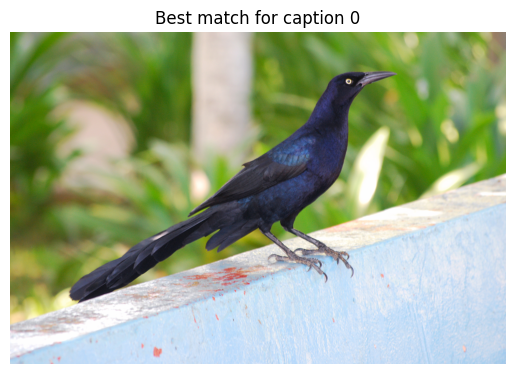

Caption [1]: This nighttime image captures a dynamic point of view from a motorcycle rider on a dimly lit street, giving a sense of motion and speed. The viewer sees the motorcycle's handlebars and front dash, including a prominent circular speedometer and a smaller gas gauge, with a key inserted in the ignition, attached to a brown leather key holder. The handlebar details and top of the seat are slightly cut off due to the narrow framing. The black body of the vintage motorcycle is evident. The road is gray asphalt, bordered by white lines, with several streetlights illuminating the right side. Ahead, the streetlights cast a soft glow on the path forward, with a blurry outline of another motorcycle visible further down the road. To the left, partially fuzzy buildings with a white and blue sign are visible, while the right side of the road features green grass and a touch of green foliage on the left.
=> Best image index: 1, sim=0.357


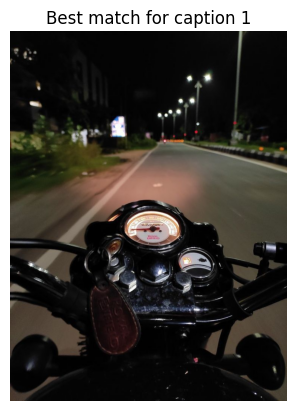

Caption [2]: The image showcases a dynamic, animated scene featuring four distinct characters, each housed within a large, square framing composed of a purple and lilac outer border. 

1. The first character, located in the upper left corner, is an anthropomorphic creature with a purple body and a striking face that blends black and pink hues, complemented by blue and pink hair. This character stands on its hind limbs, wearing white pants and a matching white crop top that accentuates its animated, lively demeanor.

2. The second character, situated next to the first, exudes a monochromatic elegance. It is a black and white figure adorned in a sharp white coat, complemented by a black tie and a pristine white shirt. Its appearance is further distinguished by its white hair and piercing green eyes, contributing to its sophisticated and somewhat mysterious aura.

3. The third character, located in the lower left quadrant of the square, resembles a playful feline creature. It possesses fo

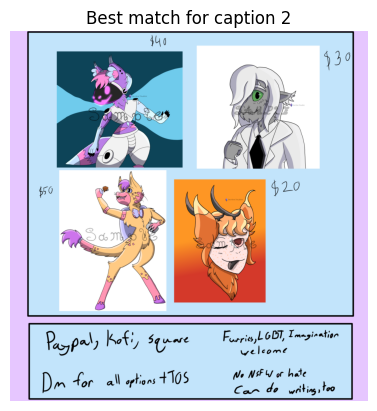

In [23]:
# 7.3 Visualize top-1 retrieval for a few captions

def show_caption_best_image(i):
    best_img_idx = sims_text_to_image[i].argmax()
    best_sim = sims_text_to_image[i, best_img_idx]

    print(f"Caption [{i}]: {captions[i]}")
    print(f"=> Best image index: {best_img_idx}, sim={best_sim:.3f}")

    plt.imshow(images[best_img_idx])
    plt.axis("off")
    plt.title(f"Best match for caption {i}")
    plt.show()

for i in range(min(3, len(captions))):
    show_caption_best_image(i)


### 8. Image → Text Retrieval (Symmetric View)

In [24]:
# 8.1 Similarity matrix: image→text

sims_image_to_text = (img_emb @ txt_emb.T).cpu().numpy()
print("Similarity matrix shape (image→text):", sims_image_to_text.shape)

# 8.2 For each image, find best caption
for i in range(len(images)):
    best_txt_idx = sims_image_to_text[i].argmax()
    best_sim = sims_image_to_text[i, best_txt_idx]

    print(f"\nImage [{i}] best caption (idx={best_txt_idx}, sim={best_sim:.3f}):")
    print(captions[best_txt_idx])


Similarity matrix shape (image→text): (10, 10)

Image [0] best caption (idx=0, sim=0.346):
This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall with red stains. The bird's sleek, elongated body is adorned with iridescent feathers that shimmer with shades of blue, purple, and green, most prominently on its wings and back. Its piercing yellow eye and long, sharp beak lend it a fierce, almost aerodynamic appearance. The bird's dark, slender legs and short talons grip the edge of the cement structure, which resembles a divider or barrier, possibly in an outdoor setting like a park or building patio. The background is a blur of green and white hues, hinting at lush tropical plants and tall trees, setting a serene, natural scene. The bird is poised, looking towards the upper right-hand corner of the frame, with its long tail feathers trailing elegantly to the left.

Image [1] best caption (idx=1, sim=0.357):
This nighttime image

### 9. Heatmap: Images vs Captions

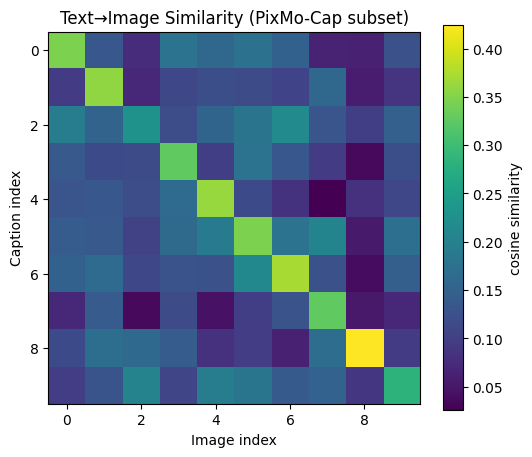

In [25]:
# 9. Heatmap of text→image similarities

plt.figure(figsize=(6, 5))
plt.imshow(sims_text_to_image, interpolation="nearest")
plt.colorbar(label="cosine similarity")
plt.title("Text→Image Similarity (PixMo-Cap subset)")
plt.xlabel("Image index")
plt.ylabel("Caption index")
plt.show()


### 10. Optional: Caption Ranking for a Single Image

In [26]:
# 10. Optional: rank captions for a single image

image_idx = 0  # change this to investigate other images
print(f"Ranking captions for image index: {image_idx}")

sims = sims_image_to_text[image_idx]
sorted_indices = np.argsort(-sims)  # descending

for rank, j in enumerate(sorted_indices[:5]):  # top-5
    print(f"rank {rank}: caption idx={j}, sim={sims[j]:.3f}")
    print("  ", captions[j][:120], "...")


Ranking captions for image index: 0
rank 0: caption idx=0, sim=0.346
   This photograph depicts a striking black bird, possibly a grackle or similar species, perched on a white cement wall wit ...
rank 1: caption idx=2, sim=0.195
   The image showcases a dynamic, animated scene featuring four distinct characters, each housed within a large, square fra ...
rank 2: caption idx=6, sim=0.149
   In this night-time photograph, a diverse crowd congregates around the entrance of a building adorned with a prominent bl ...
rank 3: caption idx=5, sim=0.142
   The image depicts a museum exhibit featuring a juxtaposition of text and photograph mounted on a wall. On the left, a pi ...
rank 4: caption idx=3, sim=0.138
   A large brown suckerfish, commonly known as a plecostomus or pleco catfish, is prominently displayed inside a home fish  ...
